<a href="https://colab.research.google.com/github/mouna0403/Tuto-llm/blob/main/Build_a_Retrieval_Augmented_Generation_(RAG2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -U langchain-groq
!pip install langchain
!pip install -qU langchain-core
!pip install -qU langchain_community
!pip install -qU langchain-text-splitter
!pip install -qU langchain-document-loaders
!pip install -qU typing_extensions
!pip install -qU langgraph
# 🚀 Installation des dépendances
!pip install langchain-ollama
!pip install ollama
!curl -fsSL https://ollama.com/install.sh | sh

# Démarrer le service Ollama en arrière-plan
import subprocess
import time
import os

# Démarrer Ollama en arrière-plan
ollama_process = subprocess.Popen(['ollama', 'serve'], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
time.sleep(5)  # Attendre que le service démarre

# Télécharger un modèle léger (Llama 3.2 3B ou Mistral 7B)
!ollama pull llama3.2:3b  # Modèle léger et rapide
# Alternatives :
# !ollama pull mistral:7b
# !ollama pull codellama:7b
# !ollama pull phi3:mini

print("✅ Installation terminée!")


ERROR: Could not find a version that satisfies the requirement langchain-text-splitter (from versions: none)
ERROR: No matching distribution found for langchain-text-splitter
ERROR: Could not find a version that satisfies the requirement langchain-document-loaders (from versions: none)
ERROR: No matching distribution found for langchain-document-loaders
>>> Cleaning up old version at /usr/local/lib/ollama
>>> Installing ollama to /usr/local
>>> Downloading Linux amd64 bundle
######################################################################## 100.0%
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.

✅ Installation terminée!


In [3]:
import getpass
import os

token=getpass.getpass("Enter API key for Groq: ")
os.environ["GROQ_API_KEY"] = token

from langchain.chat_models import init_chat_model

llm = init_chat_model("llama-3.1-8b-instant", model_provider="groq")

Enter API key for Groq: ··········


In [4]:
llm.invoke("hello, I am Maïmouna, guess the origin of my name and tell me the country(ies)")

AIMessage(content='Bonjour Maïmouna, \n\nI think your name is of West African origin. Maïmouna is a popular name in several countries in the region, particularly in:\n\n1. Senegal\n2. Mali\n3. Guinea\n4. Guinea-Bissau\n5. The Gambia\n\nIn these countries, Maïmouna is often associated with the Wolof and Fula ethnic groups. Your name is thought to be derived from the Arabic name "Ma\'muna" (معمنة), which means "safe" or "protected." In West African cultures, the name Maïmouna is often given to girls born during times of peace or prosperity.\n\nIs that correct, Maïmouna?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 151, 'prompt_tokens': 59, 'total_tokens': 210, 'completion_time': 0.261644646, 'prompt_time': 0.00384747, 'queue_time': 0.195538781, 'total_time': 0.265492116}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_3ddc9808b3', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--c1144a70-cbff-47bb-b8cf-7

In [5]:
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_ollama import OllamaEmbeddings

embeddings = OllamaEmbeddings(model="llama3.2:3b")


vector_store = InMemoryVectorStore(embeddings)

In [ ]:
%%capture --no-stderr
%pip install --upgrade --quiet langgraph langchain-community beautifulsoup4

In [6]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from typing_extensions import List, TypedDict

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

In [7]:
# Index chunks
_ = vector_store.add_documents(documents=all_splits[:5])

In [8]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

In [9]:
from langchain_core.tools import tool


@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\nContent: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

In [10]:
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode


# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}


# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])


# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}

In [11]:
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

In [18]:
!apt-get -qq update
!apt-get -qq install -y graphviz libgraphviz-dev
!pip install grandalf pygraphviz


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package libgtk2.0-common.
(Reading database ... 126441 files and directories currently installed.)
Preparing to unpack .../0-libgtk2.0-common_2.24.33-2ubuntu2.1_all.deb ...
Unpacking libgtk2.0-common (2.24.33-2ubuntu2.1) ...
Selecting previously unselected package libgtk2.0-0:amd64.
Preparing to unpack .../1-libgtk2.0-0_2.24.33-2ubuntu2.1_amd64.deb ...
Unpacking libgtk2.0-0:amd64 (2.24.33-2ubuntu2.1) ...
Selecting previously unselected package libgail18:amd64.
Preparing to unpack .../2-libgail18_2.24.33-2ubuntu2.1_amd64.deb ...
Unpacking libgail18:amd64 (2.24.33-2ubuntu2.1) ...
Selecting previously unselected package libgail-common:amd64.
Preparing to unpack .../3-libgail-common_2.24.33-2ubuntu2.1_amd64.deb ...
Unpacking libgail-common:amd64 (2.24.33-2ubuntu2.1) ...
Se

In [12]:
import pygraphviz
import grandalf

print("pygraphviz OK ✅")
print("grandalf OK ✅")


pygraphviz OK ✅
grandalf OK ✅


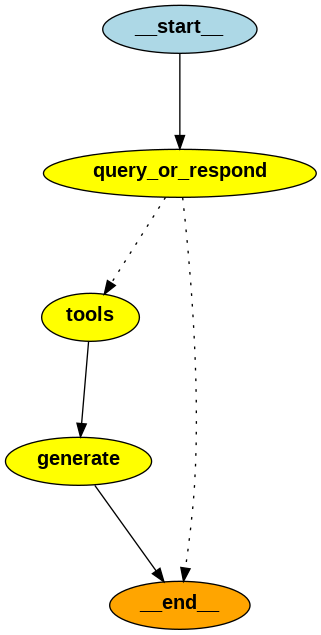

In [13]:
# Forcer Python à recharger le module qui vérifie pygraphviz
import sys
import importlib

# Supprimer le module du cache
if 'langchain_core.runnables.graph_png' in sys.modules:
    del sys.modules['langchain_core.runnables.graph_png']

# Réimporter
from langchain_core.runnables.graph_png import PngDrawer

# Maintenant essayer à nouveau
graph.get_graph().draw_png("my_graph.png")

from IPython.display import Image
Image("my_graph.png")

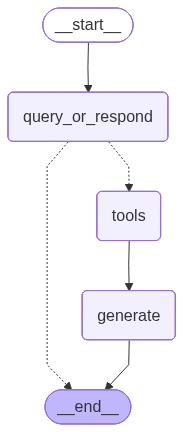

In [19]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
input_message = "Hello"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Hello
================================== Ai Message ==================================

Hello. How can I assist you today?


In [15]:
input_message = "What is Task Decomposition?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================
Tool Calls:
  retrieve (vzq5g9sw7)
 Call ID: vzq5g9sw7
  Args:
    query: Task Decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In a LLM-powered autonomous agent system, LLM

In [16]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

# Specify an ID for the thread
config = {"configurable": {"thread_id": "abc123"}}

In [17]:
input_message = "What is Task Decomposition?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================
Tool Calls:
  retrieve (g021qkwzv)
 Call ID: g021qkwzv
  Args:
    query: Task Decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In a LLM-powered autonomous agent system, LLM

In [18]:
input_message = "Can you look up some common ways of doing it?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up some common ways of doing it?
================================== Ai Message ==================================
Tool Calls:
  retrieve (vxwxtww7p)
 Call ID: vxwxtww7p
  Args:
    query: common methods of task decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In a LLM-

In [ ]:
from langchain_core.prompts import PromptTemplate

template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.

Helpful Answer:"""
custom_rag_prompt = PromptTemplate.from_template(template) #Aulieu du prompt from HUB I CAN CUSTOMIZE MINE

In [20]:
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, [retrieve], checkpointer=memory)

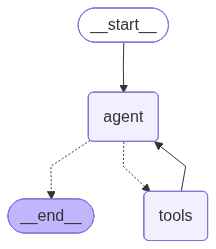

In [21]:
display(Image(agent_executor.get_graph().draw_mermaid_png()))

In [26]:
config = {"configurable": {"thread_id": "def234"}}

input_message = (
    "thanks"
)

for event in agent_executor.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

thanks
================================== Ai Message ==================================

You're welcome! If you have any more questions or need help with anything else, feel free to ask.
